In [368]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# plt.style.use('dark_background')

In [369]:
df = pd.read_csv('data/data_with_extra_columns.csv')
df.head(3)

,date,accuracy_1_%,accuracy_2_%,accuracy_3_%,accuracy_all_%,accuracy_1_avg,accuracy_2_avg,accuracy_3_avg,accuracy_all_avg,year,month,day,weekday,cost_1,cost_2,cost_3,quality_123,quality_13,quality_12
0,2024-07-01,27.5,38.8,5.4,49.6,1.321,1.523,1.185,2.052,2024,7,1,0,1100.0,11290.322581,500.0,580.259800,314.150,556.300
1,2024-07-02,26.8,38.9,5.7,49.5,1.333,1.511,1.200,2.048,2024,7,2,1,1072.0,11290.322581,500.0,578.241364,309.724,552.748
2,2024-07-03,26.0,38.0,6.0,48.6,1.303,1.508,1.201,2.025,2024,7,3,2,1040.0,11290.322581,500.0,568.728000,304.400,541.200


In [370]:
df['date'] = pd.to_datetime(df['date'])

In [371]:
N = 1_000

In [372]:
report_price = 175

In [373]:
from itertools import permutations

strategies = []
sources = [1, 2, 3]

for l in range(1, 4):   
    strategies += list(permutations(sources, l))

strategies

[(1,),
 (2,),
 (3,),
 (1, 2),
 (1, 3),
 (2, 1),
 (2, 3),
 (3, 1),
 (3, 2),
 (1, 2, 3),
 (1, 3, 2),
 (2, 1, 3),
 (2, 3, 1),
 (3, 1, 2),
 (3, 2, 1)]

Предполагаем, что если информации по твой машине не нашли в целом, то ты не платишь 

In [374]:
def calc(row, strategy, metric):
    costs = dict([(idx, row[f'cost_{idx}']) for idx in strategy])
    probabilities = dict([(idx, row[f'accuracy_{idx}_%'] / 100) for idx in strategy])

    reports = N
    cost = 0
    for idx in strategy:
        count = probabilities[idx] * reports
        
        if idx == 2: 
            cost += costs[2]
        elif idx == 1:
            cost += costs[1] * count / N
        else:
            cost += reports * 0.5

        cost += costs[idx]
        reports -= count

    if metric == 'quality':
        return N - reports
    
    return cost / (N - reports)

In [375]:
for strategy in strategies:
    name = 'quality_' + ''.join(map(str, strategy))
    df[name] = df.apply(lambda row: calc(row, strategy, 'quality'), axis=1)

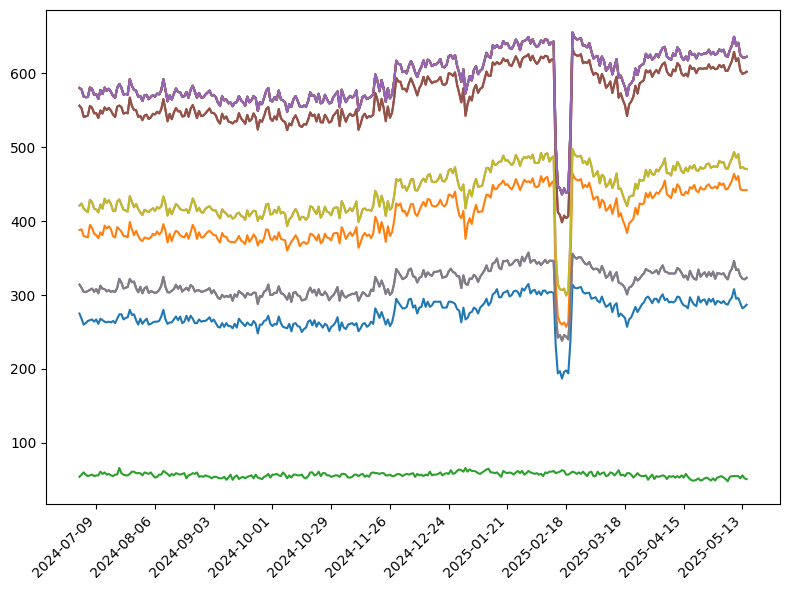

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for idx, strategy in enumerate(strategies):
    name = 'quality_' + ''.join(map(str, strategy))

    plt.plot(df.date, df[name])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.show()

In [377]:
for strategy in strategies:
    name = 'cost_for_report_' + ''.join(map(str, strategy))
    df[name] = df.apply(lambda row: calc(row, strategy, 'cost'), axis=1)

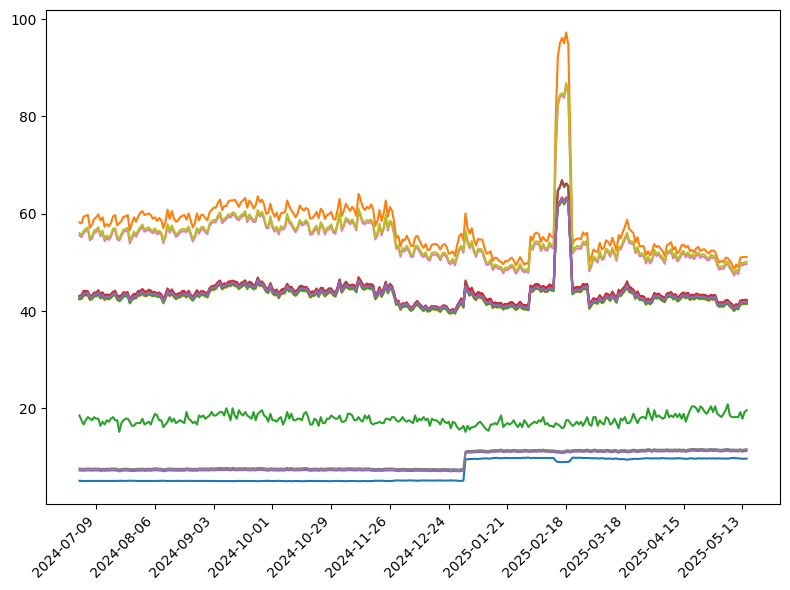

In [378]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for idx, strategy in enumerate(strategies):
    name = 'cost_for_report_' + ''.join(map(str, strategy))

    plt.plot(df.date, df[name])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

plt.show()

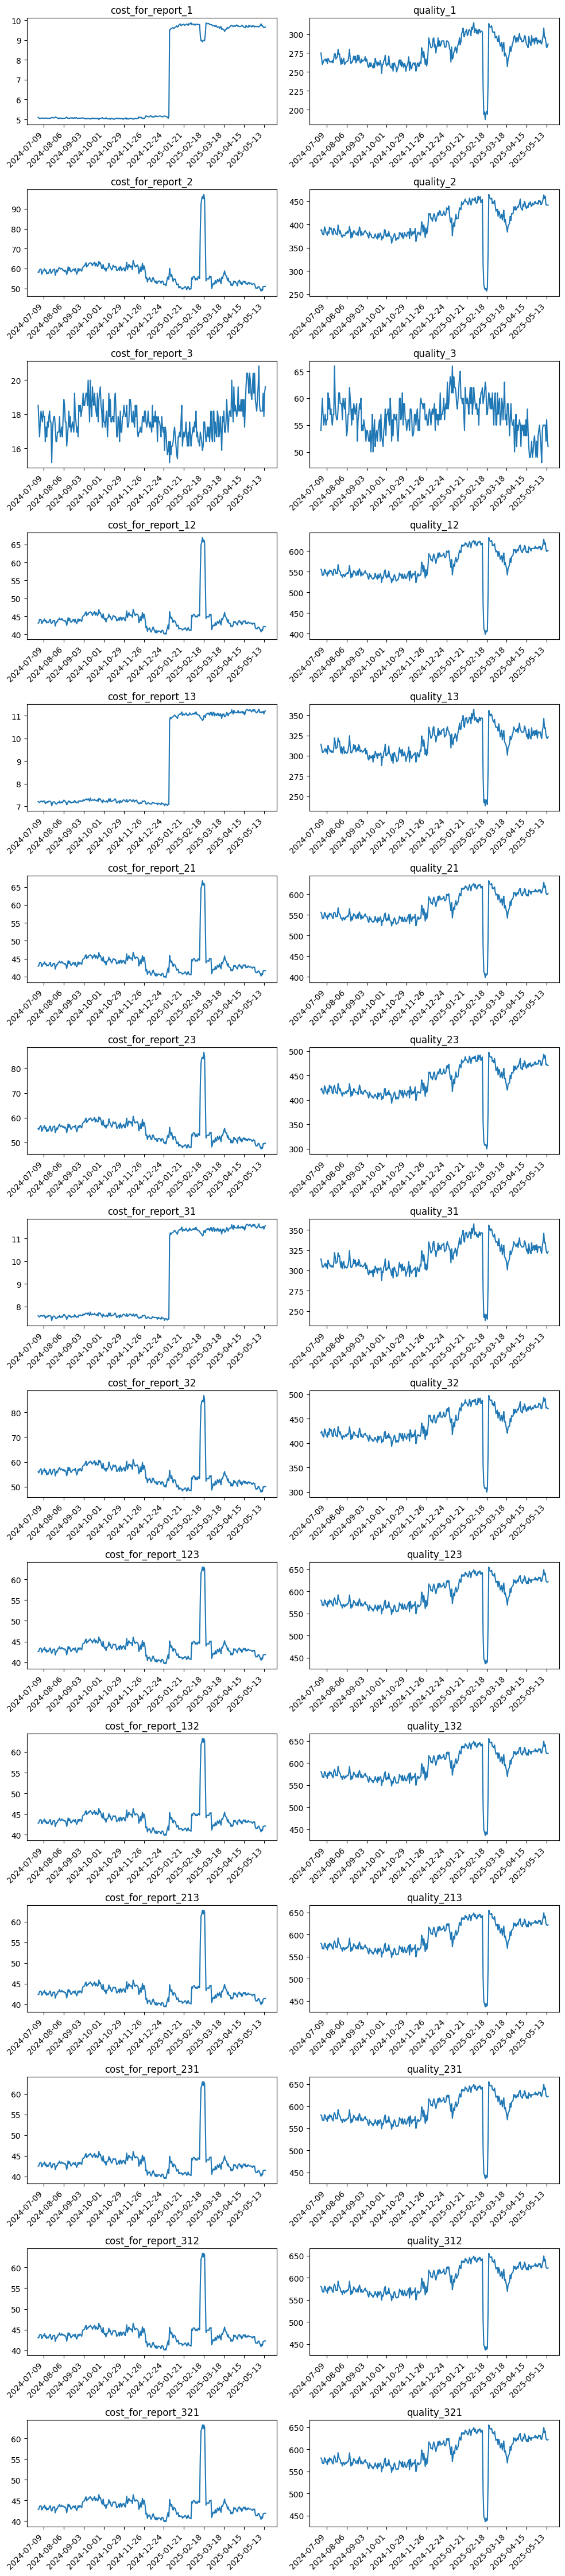

In [379]:
plt.figure(figsize=(2 * 5, len(strategies) * 3))

for idx, strategy in enumerate(strategies):
    # Стоимость
    ax = plt.subplot(len(strategies), 2, 2 * idx + 1)

    name = 'cost_for_report_' + ''.join(map(str, strategy))

    plt.plot(df.date, df[name])

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.title(name)

    # Качество
    ax = plt.subplot(len(strategies), 2, 2 * idx + 2)

    name = 'quality_' + ''.join(map(str, strategy))

    plt.plot(df.date, df[name])

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.title(name)

plt.tight_layout()

plt.show()

In [380]:
labels, costs, qualities, incomes = [], [], [], []

for strategy in strategies:
    label = ''.join(map(str, strategy))

    l = ''
    for i in strategy:
        l += str(i) + ','

    labels.append(l[:-1])

    costs.append(df['cost_for_report_' + label].median())

    qualities.append(df['quality_' + label].median())

    incomes.append((report_price - df['cost_for_report_' + label].median()) * df['quality_' + label].median())

In [381]:
metrics_df = pd.DataFrame({
    'label': labels, 
    'cost': costs, 
    'quality': qualities, 
    'income': incomes
})

metrics_df.sort_values('income', inplace=True)

In [382]:
bar_width = 0.4

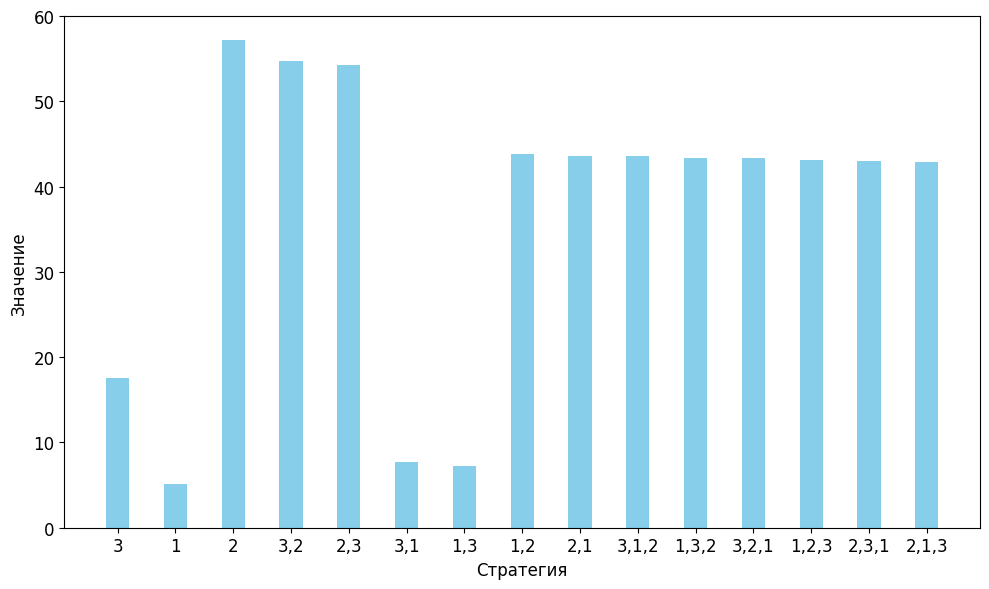

In [383]:
groups = metrics_df['label']
metric1 = metrics_df['cost'] 
index = np.arange(len(groups))  

plt.figure(figsize=(10, 6))

plt.bar(index, metric1, bar_width, color='skyblue')

plt.xlabel('Стратегия', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.xticks(index, groups, fontsize=12)  
plt.yticks(fontsize=12)

# plt.title('Средняя себестоимость одного отчета', fontsize=12)

plt.tight_layout()
plt.savefig('img1.jpg')
plt.show()

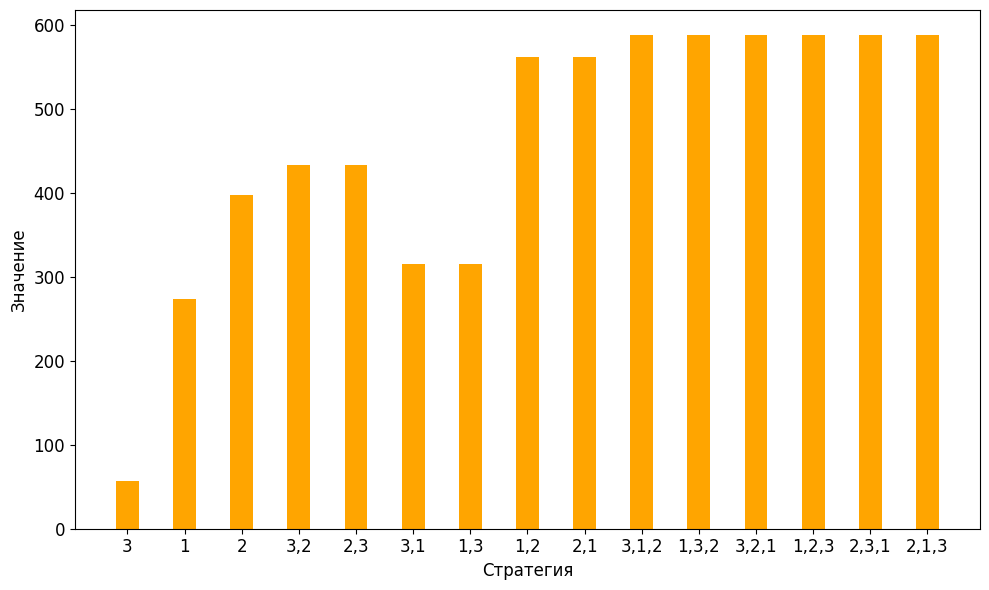

In [384]:
groups = metrics_df['label']
metric2 = metrics_df['quality']
index = np.arange(len(groups))  

plt.figure(figsize=(10, 6))

plt.bar(index, metric2, bar_width, color='orange')

plt.xlabel('Стратегия', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.xticks(index, groups, fontsize=12)  
plt.yticks(fontsize=12) 

# plt.title('Среднее качество отчетов', fontsize=12)

plt.tight_layout()
plt.savefig('img2.jpg')
plt.show()

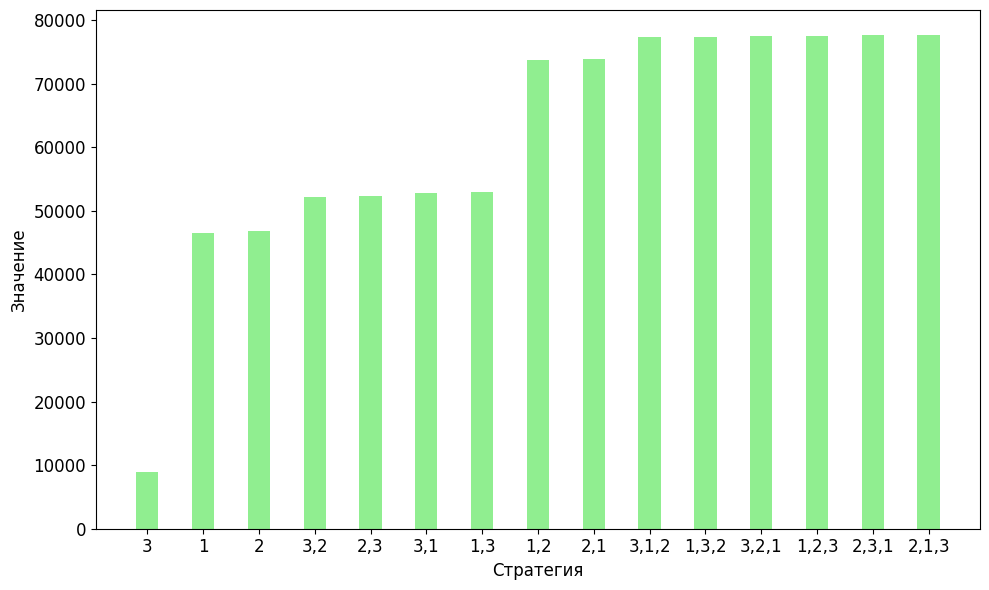

In [385]:
groups = metrics_df['label']
metric = metrics_df['income']
index = np.arange(len(groups))  

plt.figure(figsize=(10, 6))

plt.bar(index, metric, bar_width, color='lightgreen')

plt.xlabel('Стратегия', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.xticks(index, groups, fontsize=12)  
plt.yticks(fontsize=12) 

# plt.title('Предполагаемая прибыль за прошедкий период', fontsize=12)

plt.tight_layout()
plt.savefig('img3.jpg')
plt.show()

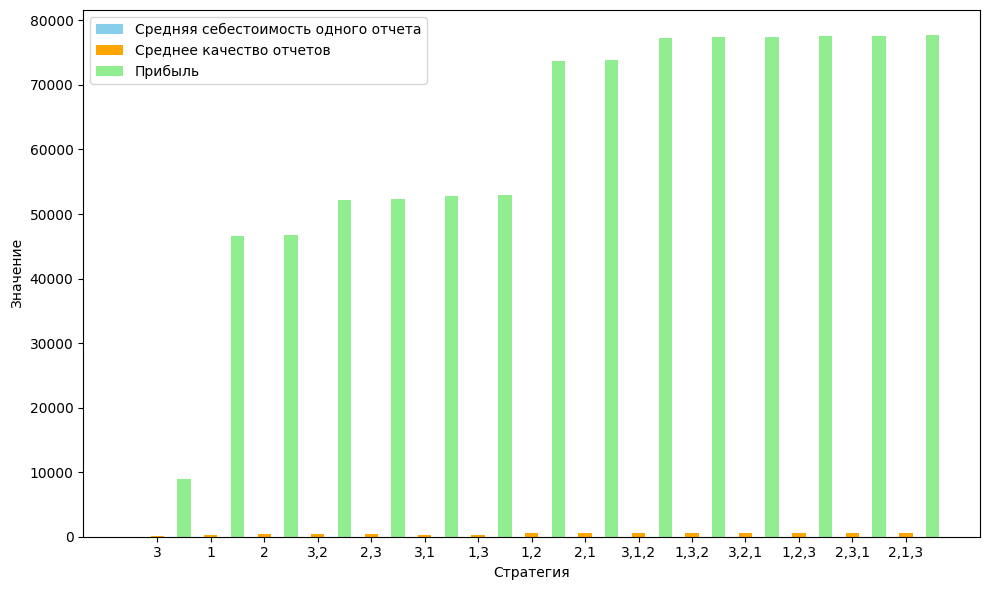

In [386]:
plt.figure(figsize=(10, 6))

groups = metrics_df['label']
metric1 = metrics_df['cost']
bar_width = 0.25 
index = np.arange(len(groups))  

plt.bar(index - 0.5, metric1, bar_width, label='Средняя себестоимость одного отчета', color='skyblue')

groups = metrics_df['label']
metric2 = metrics_df['quality']
bar_width = 0.25 
index = np.arange(len(groups))  

plt.bar(index, metric2, bar_width, label='Среднее качество отчетов', color='orange')

groups = metrics_df['label']
metric = metrics_df['income']
bar_width = 0.25 
index = np.arange(len(groups))  


plt.bar(index + 0.5, metric, bar_width, label='Прибыль', color='lightgreen')

plt.xlabel('Стратегия')
plt.ylabel('Значение')
plt.xticks(index, groups)  
plt.legend() 

plt.tight_layout()
plt.show()